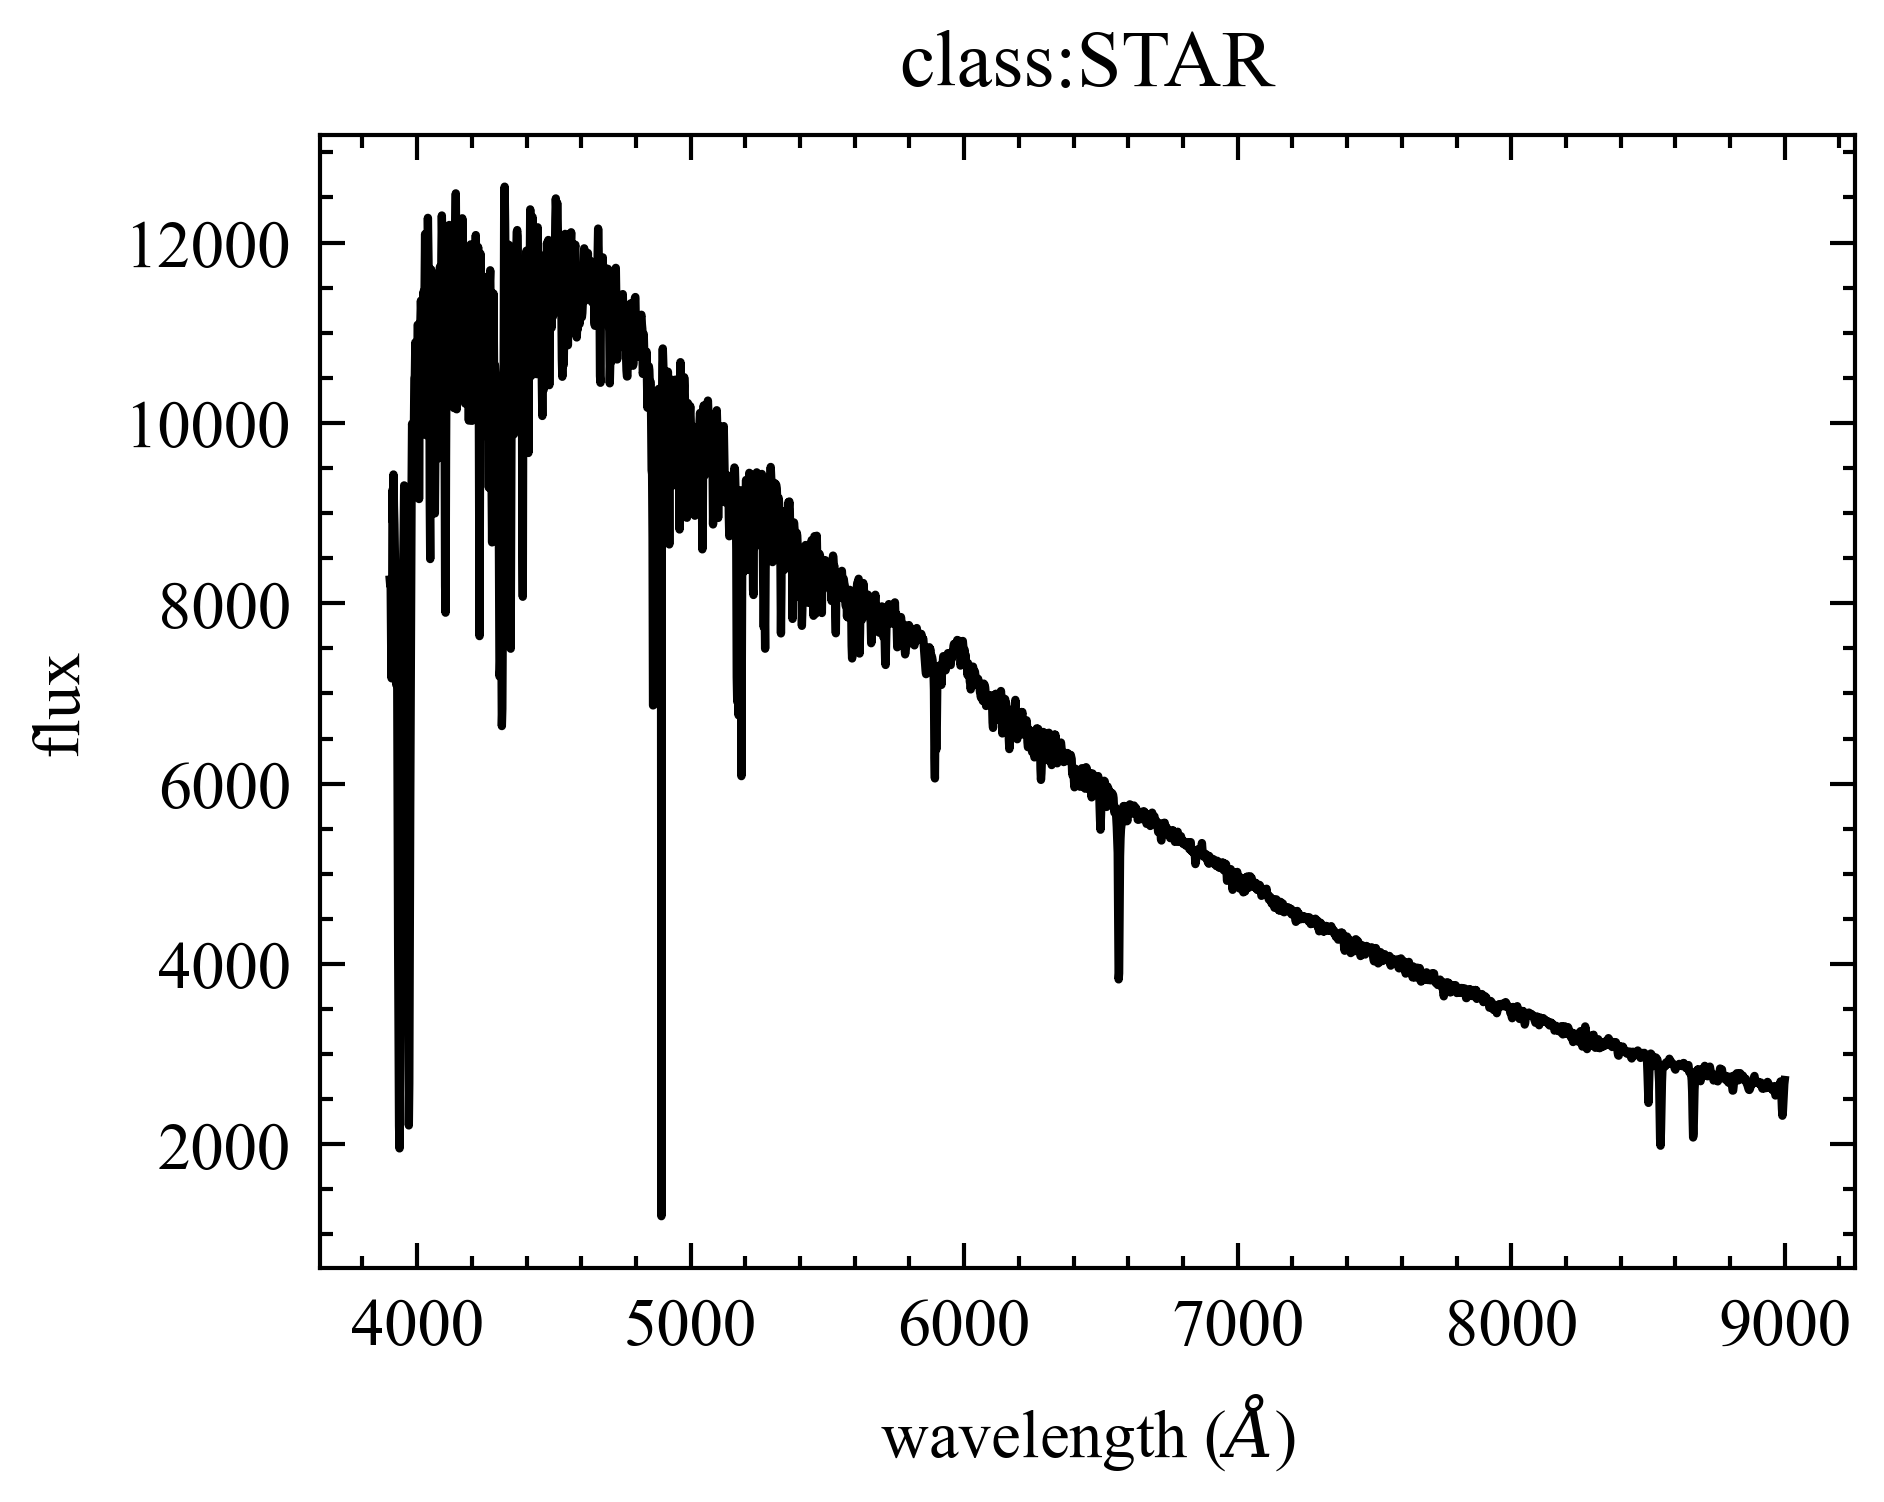

In [84]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
plt.style.use(['science','ieee'])


#解决版本问题里没有的函数
import numpy
 
def patch_asscalar(a):
    return a.item()
 
setattr(numpy, "asscalar", patch_asscalar)

def patch_alen(a):
    return a.shape[0]
 
setattr(numpy, "alen", patch_alen)



hdulist = fits.open('/data/dell5/userdir/chenhx/galaxy10/spectra_train_data/output/train_data_05.fits')
num = 5001 # the 5001st spectra in this fits file

flux = hdulist[0].data[num-1]
objid = hdulist[1].data['objid'][num-1]
label = hdulist[1].data['label'][num-1]
wavelength = np.linspace(3900,9000,3000)

c = {0:'GALAXY',1:'QSO',2:'STAR'}
plt.plot(wavelength,flux)
plt.title(f'class:{c[label]}')
plt.xlabel('wavelength ({})'.format(f'$\AA$'))
plt.ylabel('flux')
plt.show()

In [2]:
hdulist = fits.open('/data/dell5/userdir/chenhx/galaxy10/spectra_train_data/output/train_data_05.fits')
num = 5001 # the 5001st spectra in this fits file

flux = hdulist[0].data[num-1]
objid = hdulist[1].data['objid'][num-1]
label = hdulist[1].data['label'][num-1]
wavelength = np.linspace(3900,9000,3000)

In [15]:
#训练集
for i in range(10):
    filedir='/data/dell5/userdir/chenhx/galaxy10/spectra_train_data/output/train_data_0'+str(i+1)+'.fits'
    if i ==9:
        filedir='/data/dell5/userdir/chenhx/galaxy10/spectra_train_data/output/train_data_'+str(i+1)+'.fits'
    hdulist = fits.open(filedir)
    data=hdulist[0].data
    objid = hdulist[1].data['objid']
    label = hdulist[1].data['label']
    if i ==0:
        traindata=data.copy()
        trainid=objid.copy()
        trainlabel=label.copy()
    else:
        traindata=np.vstack((traindata,data))
        trainid=np.append(trainid,objid)
        trainlabel=np.append(trainlabel,label)
        
    

In [28]:
print('label=0的个数：',np.sum(trainlabel==0))
print('label=1的个数：',np.sum(trainlabel==1))
print('label=2的个数：',np.sum(trainlabel==2))

label=0的个数： 3427
label=1的个数： 1011
label=2的个数： 95562


In [4]:
hdulist = fits.open('/data/dell5/userdir/chenhx/galaxy10/spectra_train_data/output/test_data.fits')
data=hdulist[0].data
objid = hdulist[1].data['objid']
#label = hdulist[1].data['label']
testdata=data.copy()
testid=objid.copy()
#testlabel=label.copy()

In [16]:
trainlabel.shape

(100000,)

In [91]:
#learning rate=1e-5

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
import os

# 数据预处理
scaler = StandardScaler()
data_scaled = scaler.fit_transform(traindata)

# 数据洗牌
data_shuffled, labels_shuffled = shuffle(data_scaled, trainlabel, random_state=42)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(data_shuffled, labels_shuffled, test_size=0.1, random_state=42)

#分离label0 和label1
X_test0=X_test[y_test==0]
y_test0=y_test[y_test==0]
X_test1=X_test[y_test==1]
y_test1=y_test[y_test==1]

# 构建神经网络模型
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation='relu', input_shape=(3000,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 个输出，对应三个类别
])


model.summary()


# 计算类别权重
class_weights = {
    0: len(trainlabel) / (3 * 3427),  # 类别0的权重
    1: len(trainlabel) / (3 * 1011),  # 类别1的权重
    2: len(trainlabel) / (3 * 95562)  # 类别2的权重
}




# 编译模型时设置类别权重
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])#,  class_weight=class_weights)



epo=100
trainL=np.zeros(epo)
testL=np.zeros(epo)
trainacc=np.zeros(epo)
testacc=np.zeros(epo)
testL0=np.zeros(epo)
testacc0=np.zeros(epo)
testL1=np.zeros(epo)
testacc1=np.zeros(epo)


if not os.path.exists('/data/dell5/userdir/chenhx/galaxy10/sepctra_ann_models'):
    os.makedirs('/data/dell5/userdir/chenhx/galaxy10/sepctra_ann_models')


    
for epoch in range(epo):  
        history=model.fit(X_train, y_train, batch_size=64, epochs=1, validation_split=0.1,class_weight=class_weights)
        model.save(f'/data/dell5/userdir/chenhx/galaxy10/sepctra_ann_models/epoch_{epoch+1}.h5')
        test_loss, test_acc = model.evaluate(X_test, y_test)
        print('Test accuracy:', test_acc)
        
        test_loss0, test_acc0 = model.evaluate(X_test0, y_test0)
        print('Test label=0 accuracy:', test_acc0)
        test_loss1, test_acc1 = model.evaluate(X_test1, y_test1)
        print('Test label=1 accuracy:', test_acc1)
        
        
        trainL[epoch]=history.history['loss'][0]
        testL[epoch]=test_loss
        trainacc[epoch]=history.history['accuracy'][0]
        testacc[epoch]=test_acc
        
        #分离label=0,1
        testL0[epoch]=test_loss0
        testacc0[epoch]=test_acc0
        
        testL1[epoch]=test_loss1
        testacc1[epoch]=test_acc1
        
        


# 评估模型
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)



Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_188 (Dense)           (None, 1024)              3073024   
                                                                 
 dense_189 (Dense)           (None, 256)               262400    
                                                                 
 dense_190 (Dense)           (None, 64)                16448     
                                                                 
 dense_191 (Dense)           (None, 16)                1040      
                                                                 
 dense_192 (Dense)           (None, 3)                 51        
                                                                 
Total params: 3352963 (12.79 MB)
Trainable params: 3352963 (12.79 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1266/1266 [==

/home/chenghx/anaconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 1s 3ms/step - loss: 1.0266 - accuracy: 0.3080
Test accuracy: 0.30799999833106995
11/11 [==============================] - 0s 4ms/step - loss: 0.9553 - accuracy: 0.9970
Test label=0 accuracy: 0.996960461139679
4/4 [==============================] - 0s 5ms/step - loss: 0.9798 - accuracy: 0.0303
Test label=1 accuracy: 0.03030303120613098
313/313 [==============================] - 1s 3ms/step - loss: 0.8941 - accuracy: 0.4171
Test accuracy: 0.4171000123023987
11/11 [==============================] - 0s 4ms/step - loss: 0.9215 - accuracy: 0.9970
Test label=0 accuracy: 0.996960461139679
4/4 [==============================] - 0s 4ms/step - loss: 1.0277 - accuracy: 0.0303
Test label=1 accuracy: 0.03030303120613098
313/313 [==============================] - 1s 2ms/step - loss: 0.6098 - accuracy: 0.6895
Test accuracy: 0.6894999742507935
11/11 [==============================] - 0s 3ms/step - loss: 0.9192 - accuracy: 0.5258
Test label=0 accuracy: 0.525835

313/313 [==============================] - 1s 3ms/step - loss: 0.7583 - accuracy: 0.5723
Test accuracy: 0.5723000168800354
11/11 [==============================] - 0s 3ms/step - loss: 0.5125 - accuracy: 0.9179
Test label=0 accuracy: 0.9179331064224243
4/4 [==============================] - 0s 3ms/step - loss: 0.9535 - accuracy: 0.2424
Test label=1 accuracy: 0.24242424964904785
313/313 [==============================] - 1s 3ms/step - loss: 0.9590 - accuracy: 0.5467
Test accuracy: 0.5467000007629395
11/11 [==============================] - 0s 5ms/step - loss: 0.6149 - accuracy: 0.7508
Test label=0 accuracy: 0.7507598996162415
4/4 [==============================] - 0s 4ms/step - loss: 0.5123 - accuracy: 0.9495
Test label=1 accuracy: 0.9494949579238892
313/313 [==============================] - 1s 3ms/step - loss: 0.8984 - accuracy: 0.5635
Test accuracy: 0.5634999871253967
11/11 [==============================] - 0s 5ms/step - loss: 0.5465 - accuracy: 0.8541
Test label=0 accuracy: 0.854103

313/313 [==============================] - 1s 3ms/step - loss: 0.6125 - accuracy: 0.6195
Test accuracy: 0.6194999814033508
11/11 [==============================] - 0s 4ms/step - loss: 0.4269 - accuracy: 0.9362
Test label=0 accuracy: 0.936170220375061
4/4 [==============================] - 0s 4ms/step - loss: 1.3447 - accuracy: 0.1818
Test label=1 accuracy: 0.1818181872367859
313/313 [==============================] - 1s 3ms/step - loss: 0.6197 - accuracy: 0.6160
Test accuracy: 0.6159999966621399
11/11 [==============================] - 0s 3ms/step - loss: 1.5322 - accuracy: 0.2888
Test label=0 accuracy: 0.28875380754470825
4/4 [==============================] - 0s 5ms/step - loss: 0.4930 - accuracy: 0.9293
Test label=1 accuracy: 0.9292929172515869
313/313 [==============================] - 1s 3ms/step - loss: 0.7982 - accuracy: 0.5807
Test accuracy: 0.5806999802589417
11/11 [==============================] - 0s 4ms/step - loss: 0.7037 - accuracy: 0.7052
Test label=0 accuracy: 0.7051671

313/313 [==============================] - 1s 3ms/step - loss: 0.8925 - accuracy: 0.5817
Test accuracy: 0.5817000269889832
11/11 [==============================] - 0s 3ms/step - loss: 0.3546 - accuracy: 0.9149
Test label=0 accuracy: 0.914893627166748
4/4 [==============================] - 0s 5ms/step - loss: 0.7688 - accuracy: 0.5960
Test label=1 accuracy: 0.5959596037864685
313/313 [==============================] - 1s 3ms/step - loss: 0.5378 - accuracy: 0.6500
Test accuracy: 0.6499999761581421
11/11 [==============================] - 0s 3ms/step - loss: 0.6289 - accuracy: 0.8237
Test label=0 accuracy: 0.8237082362174988
4/4 [==============================] - 0s 5ms/step - loss: 0.6257 - accuracy: 0.9394
Test label=1 accuracy: 0.939393937587738
313/313 [==============================] - 1s 3ms/step - loss: 0.5999 - accuracy: 0.6331
Test accuracy: 0.6330999732017517
11/11 [==============================] - 0s 3ms/step - loss: 0.5449 - accuracy: 0.8359
Test label=0 accuracy: 0.835866272

313/313 [==============================] - 1s 3ms/step - loss: 0.5695 - accuracy: 0.6610
Test accuracy: 0.6610000133514404
11/11 [==============================] - 0s 3ms/step - loss: 0.6141 - accuracy: 0.7872
Test label=0 accuracy: 0.7872340679168701
4/4 [==============================] - 0s 3ms/step - loss: 0.5011 - accuracy: 0.9394
Test label=1 accuracy: 0.939393937587738
313/313 [==============================] - 1s 3ms/step - loss: 0.6729 - accuracy: 0.6303
Test accuracy: 0.630299985408783
11/11 [==============================] - 0s 4ms/step - loss: 0.4836 - accuracy: 0.8511
Test label=0 accuracy: 0.8510638475418091
4/4 [==============================] - 0s 5ms/step - loss: 0.5780 - accuracy: 0.8889
Test label=1 accuracy: 0.8888888955116272
313/313 [==============================] - 1s 3ms/step - loss: 0.7001 - accuracy: 0.6277
Test accuracy: 0.6276999711990356
11/11 [==============================] - 0s 5ms/step - loss: 0.4893 - accuracy: 0.8541
Test label=0 accuracy: 0.854103326

313/313 [==============================] - 1s 3ms/step - loss: 0.5020 - accuracy: 0.6844
Test accuracy: 0.6844000220298767
11/11 [==============================] - 0s 4ms/step - loss: 0.4056 - accuracy: 0.9027
Test label=0 accuracy: 0.9027355909347534
4/4 [==============================] - 0s 6ms/step - loss: 1.3106 - accuracy: 0.2424
Test label=1 accuracy: 0.24242424964904785
313/313 [==============================] - 1s 3ms/step - loss: 0.5952 - accuracy: 0.6589
Test accuracy: 0.6589000225067139
11/11 [==============================] - 0s 5ms/step - loss: 0.6967 - accuracy: 0.7264
Test label=0 accuracy: 0.7264437675476074
4/4 [==============================] - 0s 4ms/step - loss: 0.4171 - accuracy: 0.9596
Test label=1 accuracy: 0.9595959782600403
313/313 [==============================] - 1s 3ms/step - loss: 0.6222 - accuracy: 0.6532
Test accuracy: 0.6531999707221985
11/11 [==============================] - 0s 4ms/step - loss: 0.6427 - accuracy: 0.7568
Test label=0 accuracy: 0.756838

313/313 [==============================] - 1s 3ms/step - loss: 0.7318 - accuracy: 0.6247
Test accuracy: 0.6247000098228455
11/11 [==============================] - 0s 5ms/step - loss: 0.4710 - accuracy: 0.8541
Test label=0 accuracy: 0.8541033267974854
4/4 [==============================] - 0s 3ms/step - loss: 0.4762 - accuracy: 0.9293
Test label=1 accuracy: 0.9292929172515869
313/313 [==============================] - 1s 3ms/step - loss: 0.3744 - accuracy: 0.7907
Test accuracy: 0.7907000184059143
11/11 [==============================] - 0s 4ms/step - loss: 0.5581 - accuracy: 0.8511
Test label=0 accuracy: 0.8510638475418091
4/4 [==============================] - 0s 4ms/step - loss: 1.0313 - accuracy: 0.6162
Test label=1 accuracy: 0.6161616444587708
313/313 [==============================] - 1s 3ms/step - loss: 0.3957 - accuracy: 0.7587
Test accuracy: 0.7587000131607056
11/11 [==============================] - 0s 5ms/step - loss: 1.1020 - accuracy: 0.5684
Test label=0 accuracy: 0.5683890

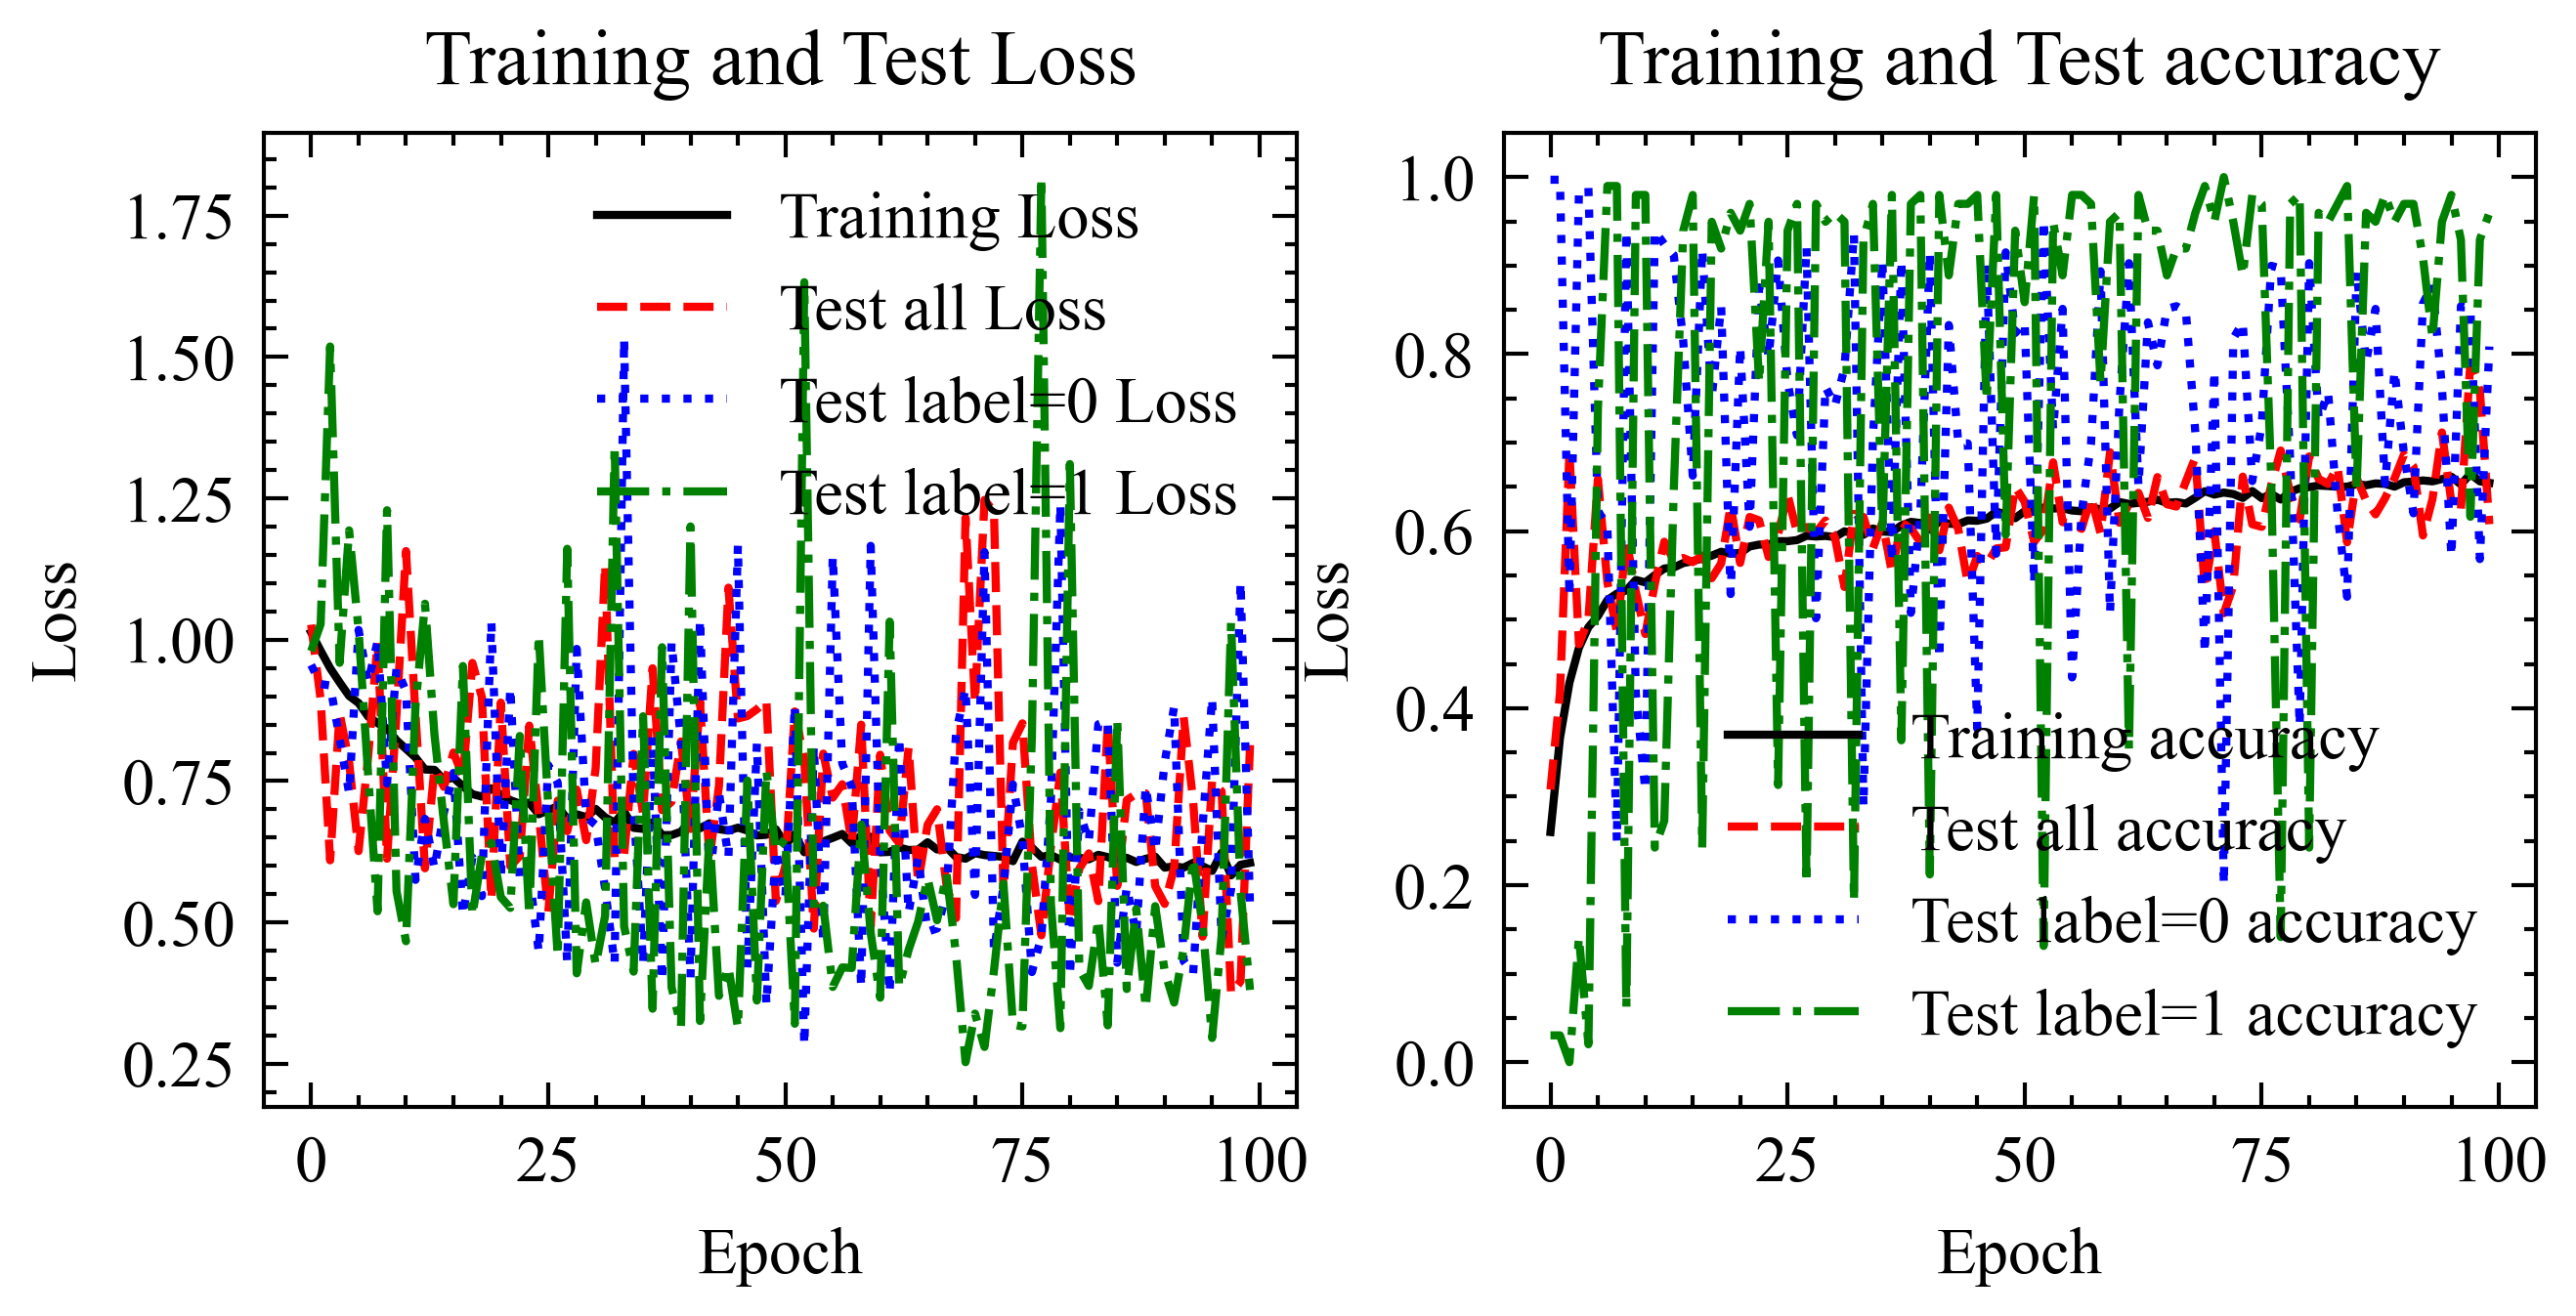

In [92]:
plt.figure(figsize=(5,2.2))
plt.subplot(1, 2, 1)
plt.plot(np.arange(epo),trainL, label='Training Loss')
plt.plot(np.arange(epo),testL, label='Test all Loss')
plt.plot(np.arange(epo),testL0, label='Test label=0 Loss')
plt.plot(np.arange(epo),testL1, label='Test label=1 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(epo),trainacc, label='Training accuracy')
plt.plot(np.arange(epo),testacc, label='Test all accuracy')
plt.plot(np.arange(epo),testacc0, label='Test label=0 accuracy')
plt.plot(np.arange(epo),testacc1, label='Test label=1 accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test accuracy')
plt.legend()

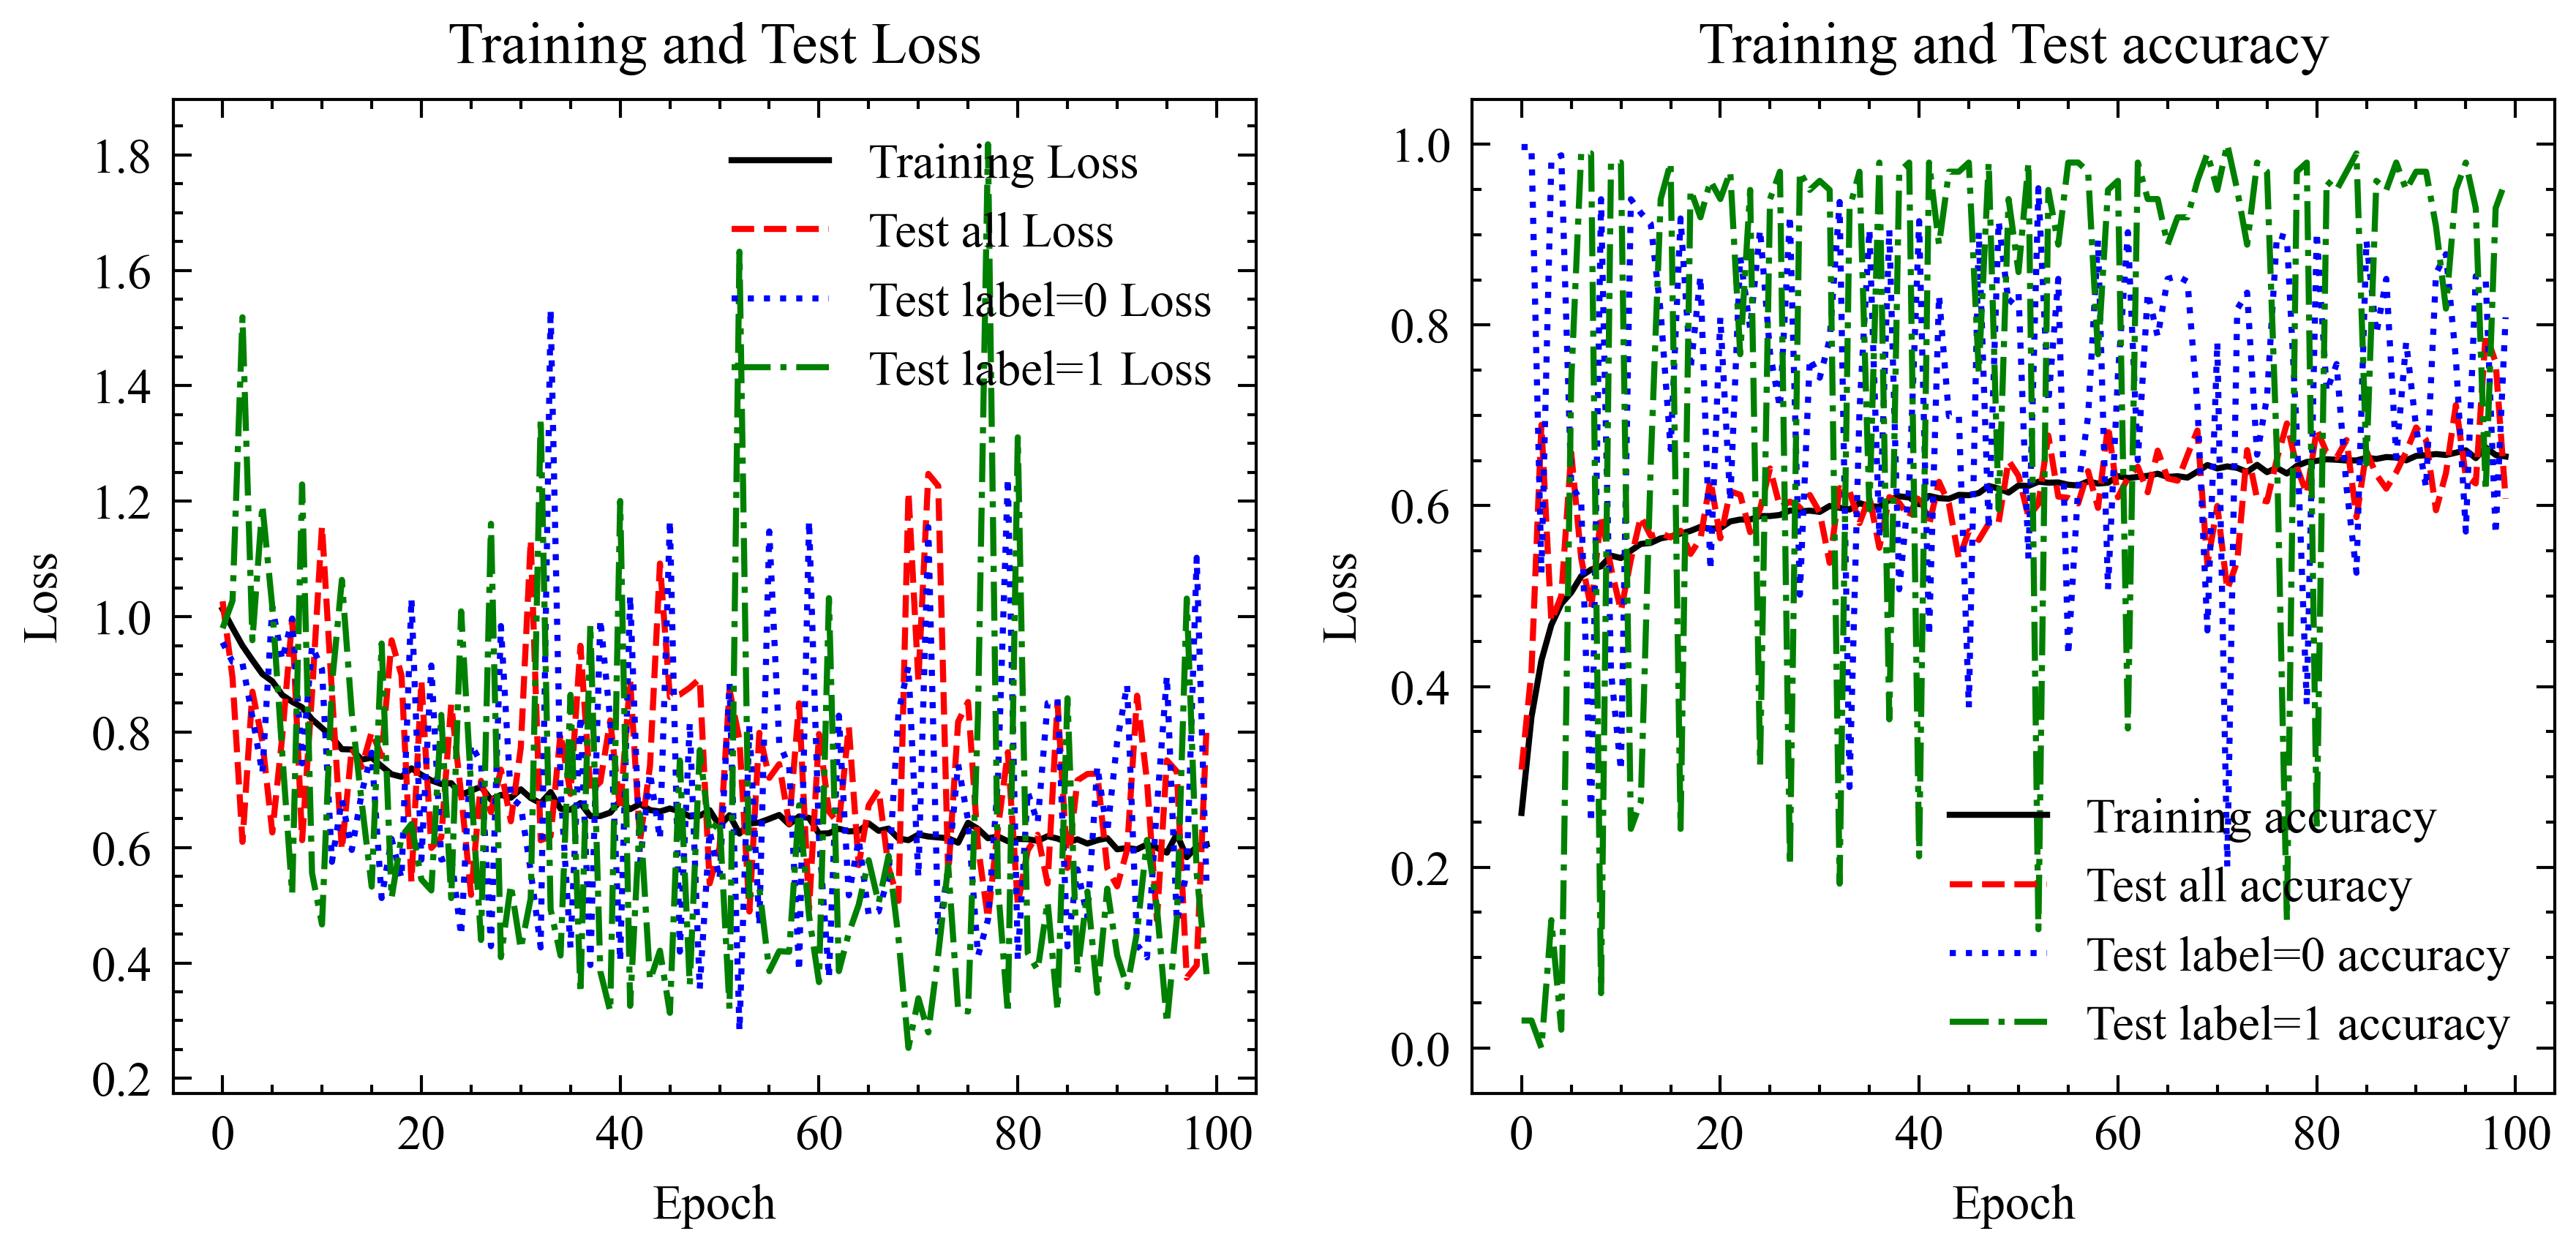

In [93]:
plt.figure(figsize=(7,3))
plt.subplot(1, 2, 1)
plt.plot(np.arange(epo),trainL, label='Training Loss')
plt.plot(np.arange(epo),testL, label='Test all Loss')
plt.plot(np.arange(epo),testL0, label='Test label=0 Loss')
plt.plot(np.arange(epo),testL1, label='Test label=1 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(epo),trainacc, label='Training accuracy')
plt.plot(np.arange(epo),testacc, label='Test all accuracy')
plt.plot(np.arange(epo),testacc0, label='Test label=0 accuracy')
plt.plot(np.arange(epo),testacc1, label='Test label=1 accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test accuracy')
plt.legend()

In [94]:
acc_012=testacc+testacc0+testacc1

print(np.argmax(acc_012),np.max(acc_012))
ind=np.argmax(acc_012)
print(ind,testacc[ind],testacc0[ind],testacc1[ind])

94 2.4239128828048706
94 0.7114999890327454 0.7629179358482361 0.9494949579238892


array([0.        , 0.        , 0.99696046, 0.98784196, 0.96656537,
       0.84194529, 0.13981763, 0.94224924, 0.77507597, 0.45288754,
       0.16109422, 0.50759876, 0.20668693, 0.81155014, 0.57750762,
       0.11550152, 0.65349543, 0.84194529, 0.78419453, 0.52887535,
       0.75379938, 0.51367784, 0.85714287, 0.5714286 , 0.82370824,
       0.71428573, 0.69300914, 0.78115499, 0.83282673, 0.31306991,
       0.47416413, 0.76899695, 0.71428573, 0.82978725, 0.68389058,
       0.71732521, 0.83586627, 0.92401218, 0.7598784 , 0.6200608 ,
       0.67173254, 0.34650457, 0.82978725, 0.67781156, 0.58662611,
       0.50455928, 0.46200609, 0.8905775 , 0.80851066, 0.95744681,
       0.93617022, 0.37386018, 0.79331309, 0.84802431, 0.90577507,
       0.69300914, 0.83282673, 0.88449848, 0.88145894, 0.64437687,
       0.77507597, 0.67781156, 0.72036475, 0.66565347, 0.86018234,
       0.7507599 , 0.84498483, 0.79027355, 0.65349543, 0.78115499,
       0.65653497, 0.77203649, 0.6200608 , 0.88753802, 0.74468

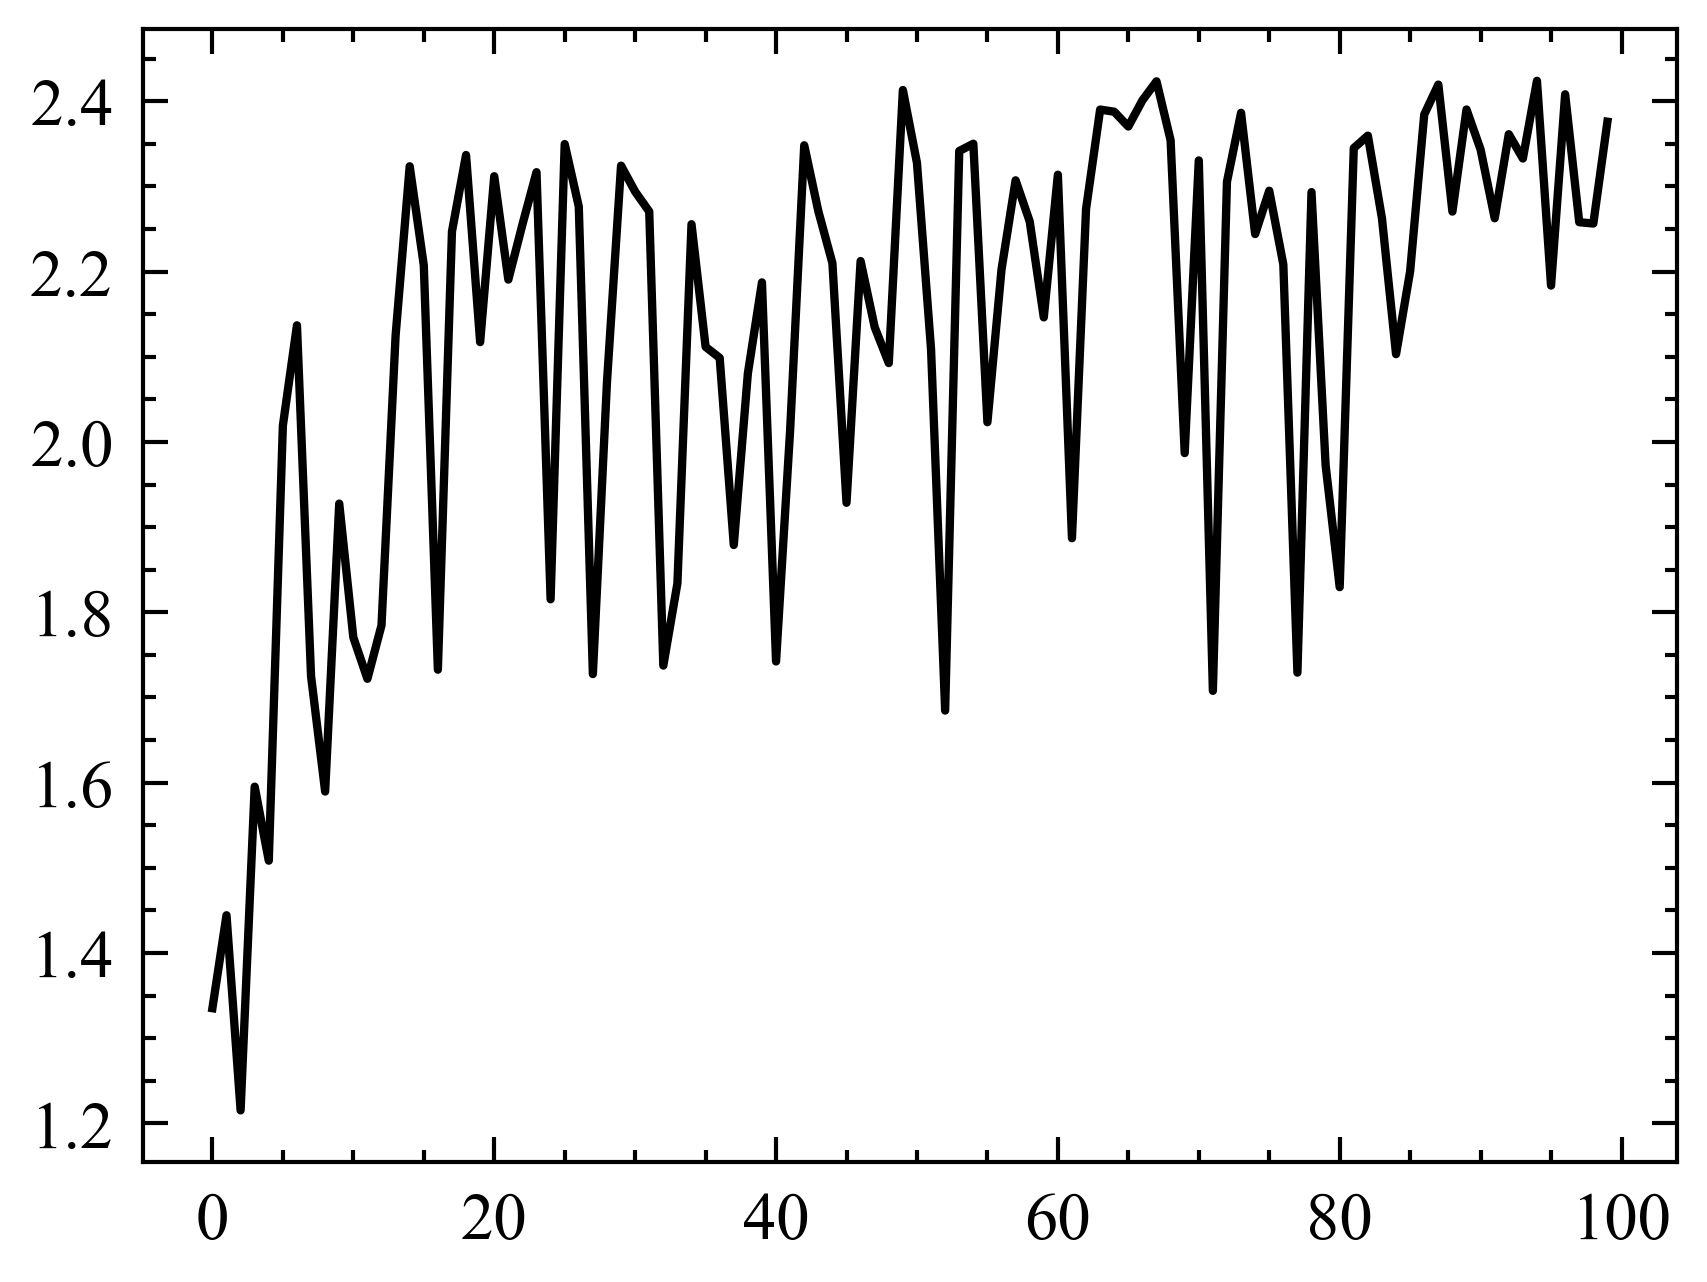

In [95]:
plt.plot(np.arange(epo),acc_012, label='Test label=0,1,2 accuracy')

(20000,)

In [ ]:
##########最佳模型！！！！！！！！！！！！！

In [149]:
##########最佳模型！！！！！！！！！！！！！
##########最佳模型！！！！！！！！！！！！！
#learning rate=1e-5 resample

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
import os

# 数据预处理
scaler = StandardScaler()
data_scaled = scaler.fit_transform(traindata)

# 数据洗牌
data_shuffled, labels_shuffled = shuffle(data_scaled, trainlabel, random_state=42)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(data_shuffled, labels_shuffled, test_size=0.1, random_state=42)


#重采样， label=0的增加5倍，label=1的增加15倍
X0=X_train[y_train==0]
y0=y_train[y_train==0]
X1=X_train[y_train==1]
y1=y_train[y_train==1]

for i in range(5):
    X_train=np.vstack((X_train,X0))
    y_train=np.append(y_train,y0)
for i in range(15):
    X_train=np.vstack((X_train,X1))
    y_train=np.append(y_train,y1)
    
X_train, y_train = shuffle(X_train, y_train, random_state=37)



#分离label0 和label1
X_test0=X_test[y_test==0]
y_test0=y_test[y_test==0]
X_test1=X_test[y_test==1]
y_test1=y_test[y_test==1]

# 构建神经网络模型
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation='relu', input_shape=(3000,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 个输出，对应三个类别
])


model.summary()


# 计算类别权重
class_weights = {
    0: len(trainlabel) / (3 * 3427)/5,  # 类别0的权重
    1: len(trainlabel) / (3 * 1011)/15,  # 类别1的权重
    2: len(trainlabel) / (3 * 95562)  # 类别2的权重
}




# 编译模型时设置类别权重
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])#,  class_weight=class_weights)



epo=100
trainL=np.zeros(epo)
testL=np.zeros(epo)
trainacc=np.zeros(epo)
testacc=np.zeros(epo)
testL0=np.zeros(epo)
testacc0=np.zeros(epo)
testL1=np.zeros(epo)
testacc1=np.zeros(epo)


if not os.path.exists('/data/dell5/userdir/chenhx/galaxy10/sepctra_ann_models_resample'):
    os.makedirs('/data/dell5/userdir/chenhx/galaxy10/sepctra_ann_models_resample')


    
for epoch in range(epo):  
        history=model.fit(X_train, y_train, batch_size=64, epochs=1, validation_split=0.1,class_weight=class_weights)
        model.save(f'/data/dell5/userdir/chenhx/galaxy10/sepctra_ann_models_resample/epoch_{epoch+1}.h5')
        test_loss, test_acc = model.evaluate(X_test, y_test)
        print('Test accuracy:', test_acc)
        
        test_loss0, test_acc0 = model.evaluate(X_test0, y_test0)
        print('Test label=0 accuracy:', test_acc0)
        test_loss1, test_acc1 = model.evaluate(X_test1, y_test1)
        print('Test label=1 accuracy:', test_acc1)
        
        
        trainL[epoch]=history.history['loss'][0]
        testL[epoch]=test_loss
        trainacc[epoch]=history.history['accuracy'][0]
        testacc[epoch]=test_acc
        
        #分离label=0,1
        testL0[epoch]=test_loss0
        testacc0[epoch]=test_acc0
        
        testL1[epoch]=test_loss1
        testacc1[epoch]=test_acc1
        
        


# 评估模型
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)



Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_198 (Dense)           (None, 1024)              3073024   
                                                                 
 dense_199 (Dense)           (None, 256)               262400    
                                                                 
 dense_200 (Dense)           (None, 64)                16448     
                                                                 
 dense_201 (Dense)           (None, 16)                1040      
                                                                 
 dense_202 (Dense)           (None, 3)                 51        
                                                                 
Total params: 3352963 (12.79 MB)
Trainable params: 3352963 (12.79 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1676/1676 [==

/home/chenghx/anaconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 1s 2ms/step - loss: 0.8838 - accuracy: 0.5014
Test accuracy: 0.5013999938964844
11/11 [==============================] - 0s 2ms/step - loss: 0.9834 - accuracy: 0.0000e+00
Test label=0 accuracy: 0.0
4/4 [==============================] - 0s 3ms/step - loss: 0.8357 - accuracy: 1.0000
Test label=1 accuracy: 1.0
313/313 [==============================] - 1s 2ms/step - loss: 0.8594 - accuracy: 0.5423
Test accuracy: 0.5422999858856201
11/11 [==============================] - 0s 2ms/step - loss: 0.8736 - accuracy: 0.5167
Test label=0 accuracy: 0.5167173147201538
4/4 [==============================] - 0s 3ms/step - loss: 0.7855 - accuracy: 0.9798
Test label=1 accuracy: 0.9797979593276978
313/313 [==============================] - 1s 2ms/step - loss: 0.7951 - accuracy: 0.5777
Test accuracy: 0.5777000188827515
11/11 [==============================] - 0s 2ms/step - loss: 0.7502 - accuracy: 0.8511
Test label=0 accuracy: 0.8510638475418091
4/4 [===========

313/313 [==============================] - 1s 2ms/step - loss: 0.5897 - accuracy: 0.6524
Test accuracy: 0.652400016784668
11/11 [==============================] - 0s 2ms/step - loss: 0.6959 - accuracy: 0.7508
Test label=0 accuracy: 0.7507598996162415
4/4 [==============================] - 0s 3ms/step - loss: 0.3679 - accuracy: 0.9596
Test label=1 accuracy: 0.9595959782600403
313/313 [==============================] - 1s 2ms/step - loss: 0.6659 - accuracy: 0.6380
Test accuracy: 0.6380000114440918
11/11 [==============================] - 0s 2ms/step - loss: 0.4990 - accuracy: 0.8541
Test label=0 accuracy: 0.8541033267974854
4/4 [==============================] - 0s 3ms/step - loss: 0.4609 - accuracy: 0.9192
Test label=1 accuracy: 0.9191918969154358
313/313 [==============================] - 1s 2ms/step - loss: 0.9720 - accuracy: 0.6007
Test accuracy: 0.6007000207901001
11/11 [==============================] - 0s 2ms/step - loss: 0.2917 - accuracy: 0.9271
Test label=0 accuracy: 0.92705166

313/313 [==============================] - 1s 2ms/step - loss: 0.4003 - accuracy: 0.7629
Test accuracy: 0.7628999948501587
11/11 [==============================] - 0s 2ms/step - loss: 0.7649 - accuracy: 0.7416
Test label=0 accuracy: 0.7416413426399231
4/4 [==============================] - 0s 3ms/step - loss: 0.4068 - accuracy: 0.9596
Test label=1 accuracy: 0.9595959782600403
313/313 [==============================] - 1s 2ms/step - loss: 0.5098 - accuracy: 0.7165
Test accuracy: 0.7164999842643738
11/11 [==============================] - 0s 2ms/step - loss: 0.4272 - accuracy: 0.8632
Test label=0 accuracy: 0.8632218837738037
4/4 [==============================] - 0s 4ms/step - loss: 0.5430 - accuracy: 0.8687
Test label=1 accuracy: 0.868686854839325
313/313 [==============================] - 1s 2ms/step - loss: 0.6069 - accuracy: 0.6985
Test accuracy: 0.6984999775886536
11/11 [==============================] - 0s 2ms/step - loss: 0.4502 - accuracy: 0.8419
Test label=0 accuracy: 0.84194529

313/313 [==============================] - 1s 2ms/step - loss: 0.4743 - accuracy: 0.7493
Test accuracy: 0.7493000030517578
11/11 [==============================] - 0s 2ms/step - loss: 0.5700 - accuracy: 0.8024
Test label=0 accuracy: 0.802431583404541
4/4 [==============================] - 0s 2ms/step - loss: 0.3510 - accuracy: 0.9596
Test label=1 accuracy: 0.9595959782600403
313/313 [==============================] - 1s 2ms/step - loss: 0.4542 - accuracy: 0.7577
Test accuracy: 0.7577000260353088
11/11 [==============================] - 0s 2ms/step - loss: 0.5082 - accuracy: 0.8116
Test label=0 accuracy: 0.8115501403808594
4/4 [==============================] - 0s 3ms/step - loss: 0.3958 - accuracy: 0.9495
Test label=1 accuracy: 0.9494949579238892
313/313 [==============================] - 1s 2ms/step - loss: 0.3917 - accuracy: 0.7773
Test accuracy: 0.7773000001907349
11/11 [==============================] - 0s 2ms/step - loss: 0.4681 - accuracy: 0.8480
Test label=0 accuracy: 0.84802430

313/313 [==============================] - 1s 2ms/step - loss: 0.3224 - accuracy: 0.8235
Test accuracy: 0.8234999775886536
11/11 [==============================] - 0s 2ms/step - loss: 0.4854 - accuracy: 0.8450
Test label=0 accuracy: 0.8449848294258118
4/4 [==============================] - 0s 2ms/step - loss: 0.5000 - accuracy: 0.9293
Test label=1 accuracy: 0.9292929172515869
313/313 [==============================] - 1s 2ms/step - loss: 0.2495 - accuracy: 0.8655
Test accuracy: 0.8654999732971191
11/11 [==============================] - 0s 2ms/step - loss: 0.7334 - accuracy: 0.7599
Test label=0 accuracy: 0.759878396987915
4/4 [==============================] - 0s 3ms/step - loss: 0.4829 - accuracy: 0.9394
Test label=1 accuracy: 0.939393937587738
313/313 [==============================] - 1s 2ms/step - loss: 0.6575 - accuracy: 0.7291
Test accuracy: 0.7290999889373779
11/11 [==============================] - 0s 2ms/step - loss: 0.4746 - accuracy: 0.7872
Test label=0 accuracy: 0.787234067

313/313 [==============================] - 1s 2ms/step - loss: 0.3682 - accuracy: 0.7964
Test accuracy: 0.7964000105857849
11/11 [==============================] - 0s 3ms/step - loss: 0.2425 - accuracy: 0.9271
Test label=0 accuracy: 0.9270516633987427
4/4 [==============================] - 0s 3ms/step - loss: 0.9190 - accuracy: 0.7172
Test label=1 accuracy: 0.7171717286109924
313/313 [==============================] - 1s 2ms/step - loss: 0.7300 - accuracy: 0.7256
Test accuracy: 0.725600004196167
11/11 [==============================] - 0s 2ms/step - loss: 0.4490 - accuracy: 0.7781
Test label=0 accuracy: 0.7781155109405518
4/4 [==============================] - 0s 3ms/step - loss: 0.3432 - accuracy: 0.9596
Test label=1 accuracy: 0.9595959782600403
313/313 [==============================] - 1s 2ms/step - loss: 0.2488 - accuracy: 0.8718
Test accuracy: 0.8718000054359436
11/11 [==============================] - 0s 2ms/step - loss: 0.4704 - accuracy: 0.8359
Test label=0 accuracy: 0.83586627

313/313 [==============================] - 1s 2ms/step - loss: 0.2708 - accuracy: 0.8570
Test accuracy: 0.8569999933242798
11/11 [==============================] - 0s 2ms/step - loss: 0.4739 - accuracy: 0.8085
Test label=0 accuracy: 0.8085106611251831
4/4 [==============================] - 0s 3ms/step - loss: 0.4972 - accuracy: 0.9495
Test label=1 accuracy: 0.9494949579238892
313/313 [==============================] - 1s 2ms/step - loss: 0.5314 - accuracy: 0.7674
Test accuracy: 0.7674000263214111
11/11 [==============================] - 0s 2ms/step - loss: 0.2395 - accuracy: 0.9240
Test label=0 accuracy: 0.9240121841430664
4/4 [==============================] - 0s 3ms/step - loss: 0.8466 - accuracy: 0.7576
Test label=1 accuracy: 0.7575757503509521
313/313 [==============================] - 1s 2ms/step - loss: 0.1899 - accuracy: 0.9196
Test accuracy: 0.9196000099182129
11/11 [==============================] - 0s 2ms/step - loss: 0.7744 - accuracy: 0.6809
Test label=0 accuracy: 0.6808510

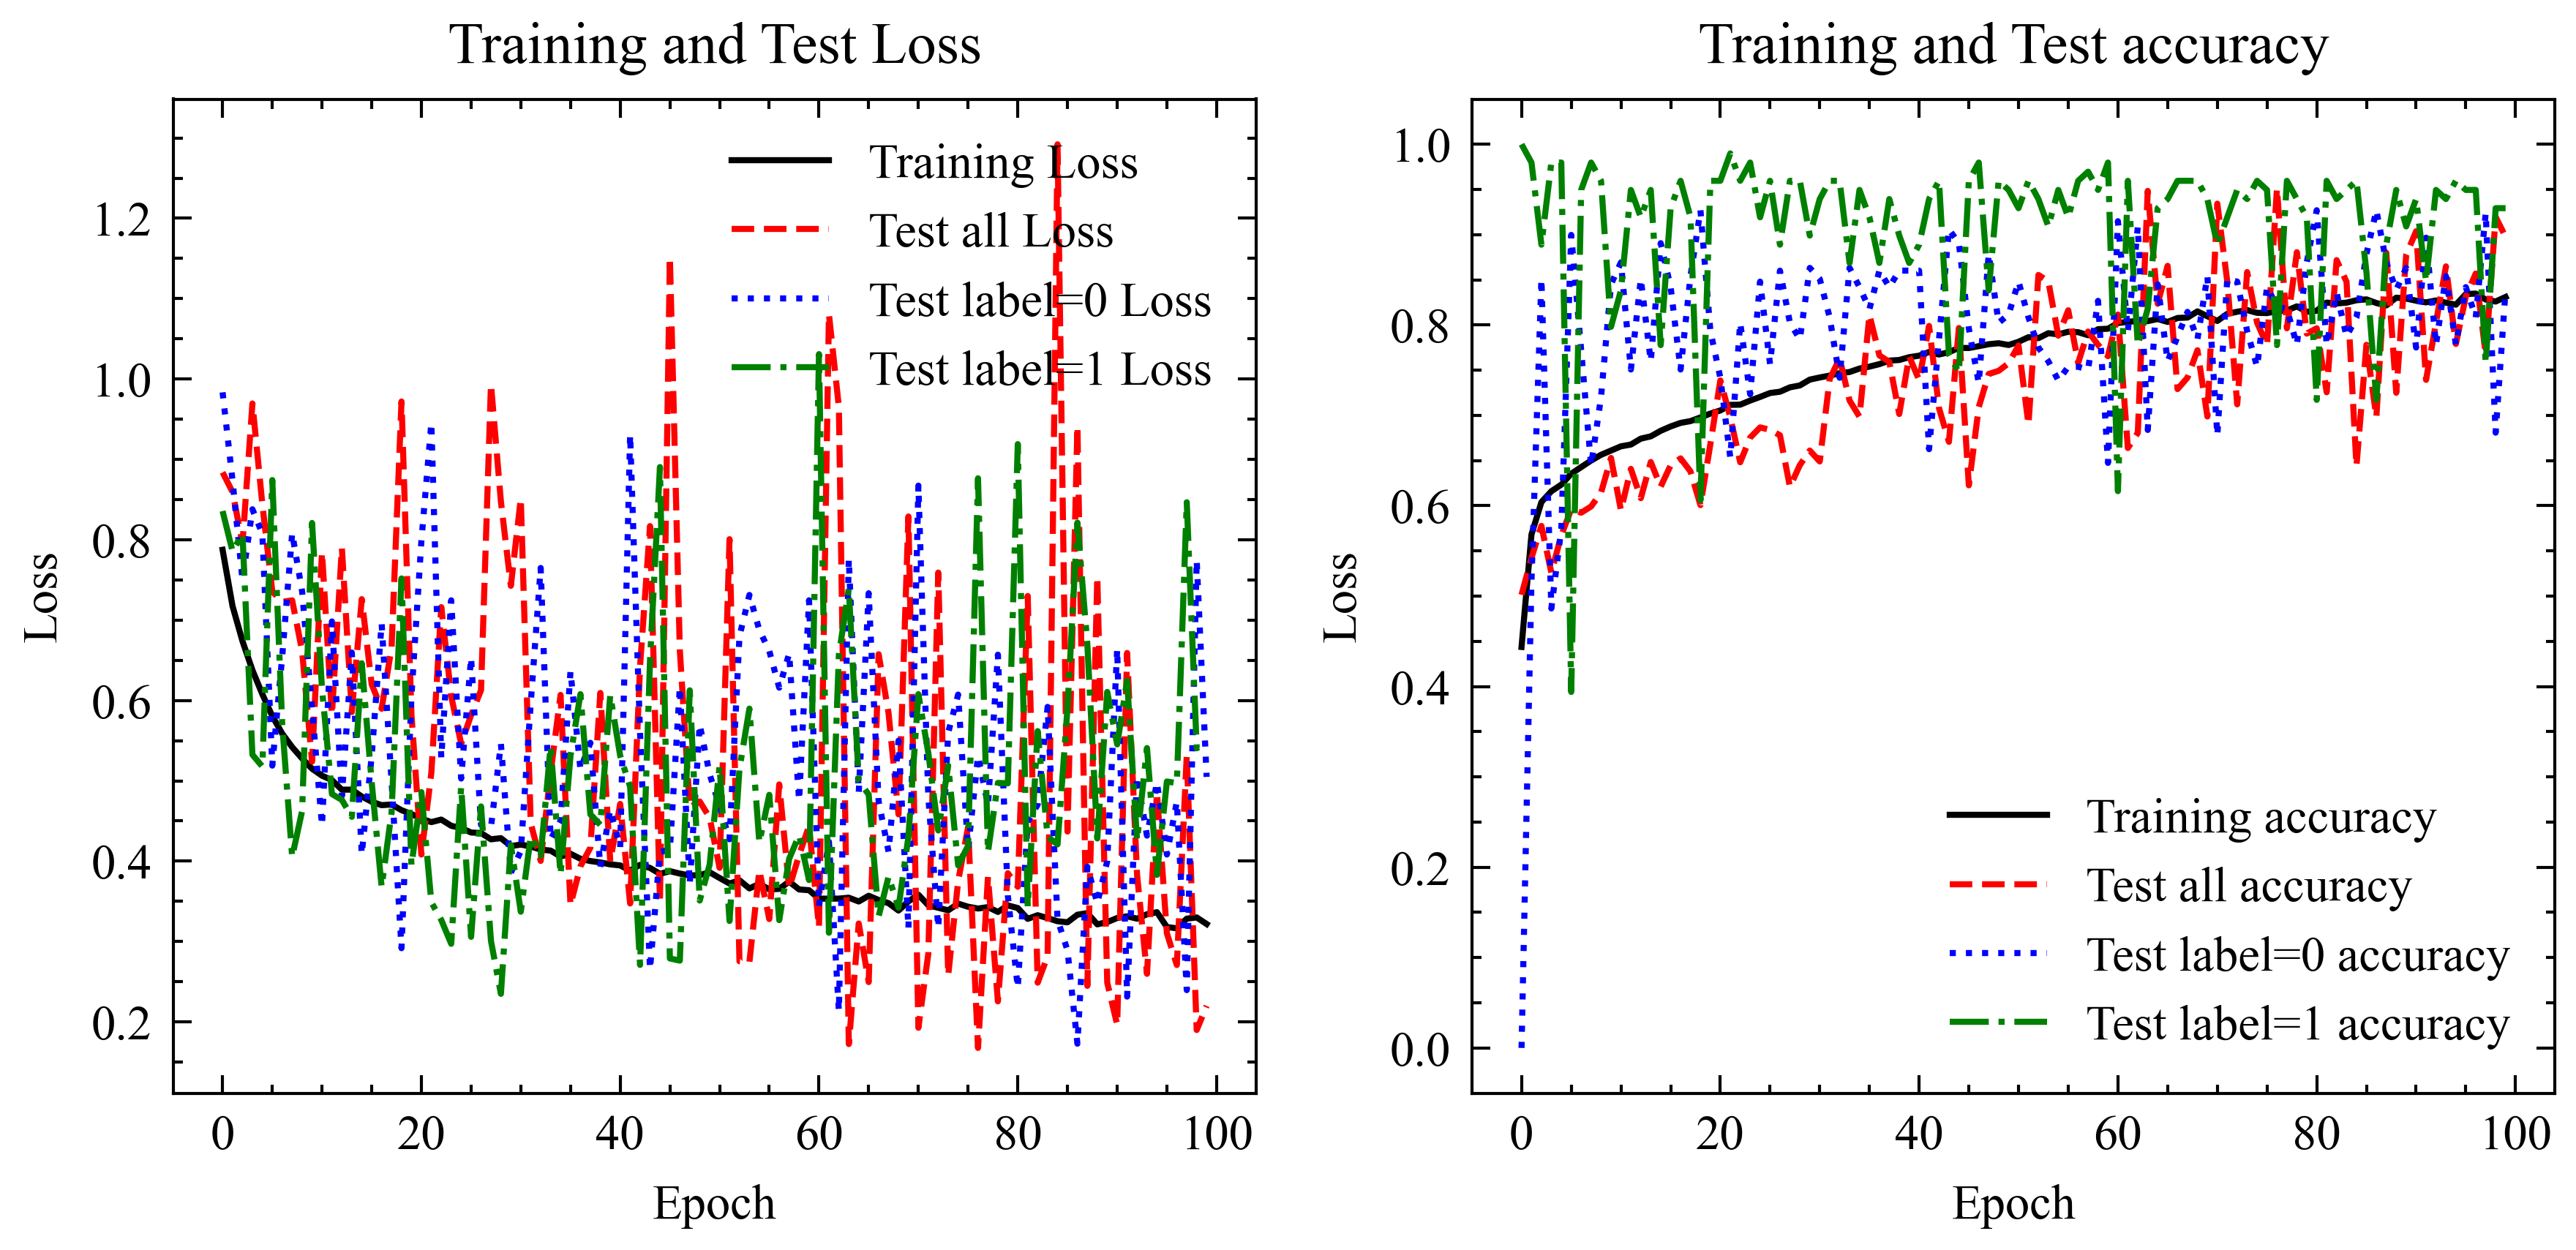

In [150]:
plt.figure(figsize=(7,3))
plt.subplot(1, 2, 1)
plt.plot(np.arange(epo),trainL, label='Training Loss')
plt.plot(np.arange(epo),testL, label='Test all Loss')
plt.plot(np.arange(epo),testL0, label='Test label=0 Loss')
plt.plot(np.arange(epo),testL1, label='Test label=1 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(epo),trainacc, label='Training accuracy')
plt.plot(np.arange(epo),testacc, label='Test all accuracy')
plt.plot(np.arange(epo),testacc0, label='Test label=0 accuracy')
plt.plot(np.arange(epo),testacc1, label='Test label=1 accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test accuracy')
plt.legend()

In [151]:
acc_012=testacc+testacc0+testacc1

print(np.argmax(acc_012),np.max(acc_012))
ind=np.argmax(acc_012)
print(ind,testacc[ind],testacc0[ind],testacc1[ind])

99 2.6656986474990845
99 0.8974999785423279 0.8389057517051697 0.9292929172515869


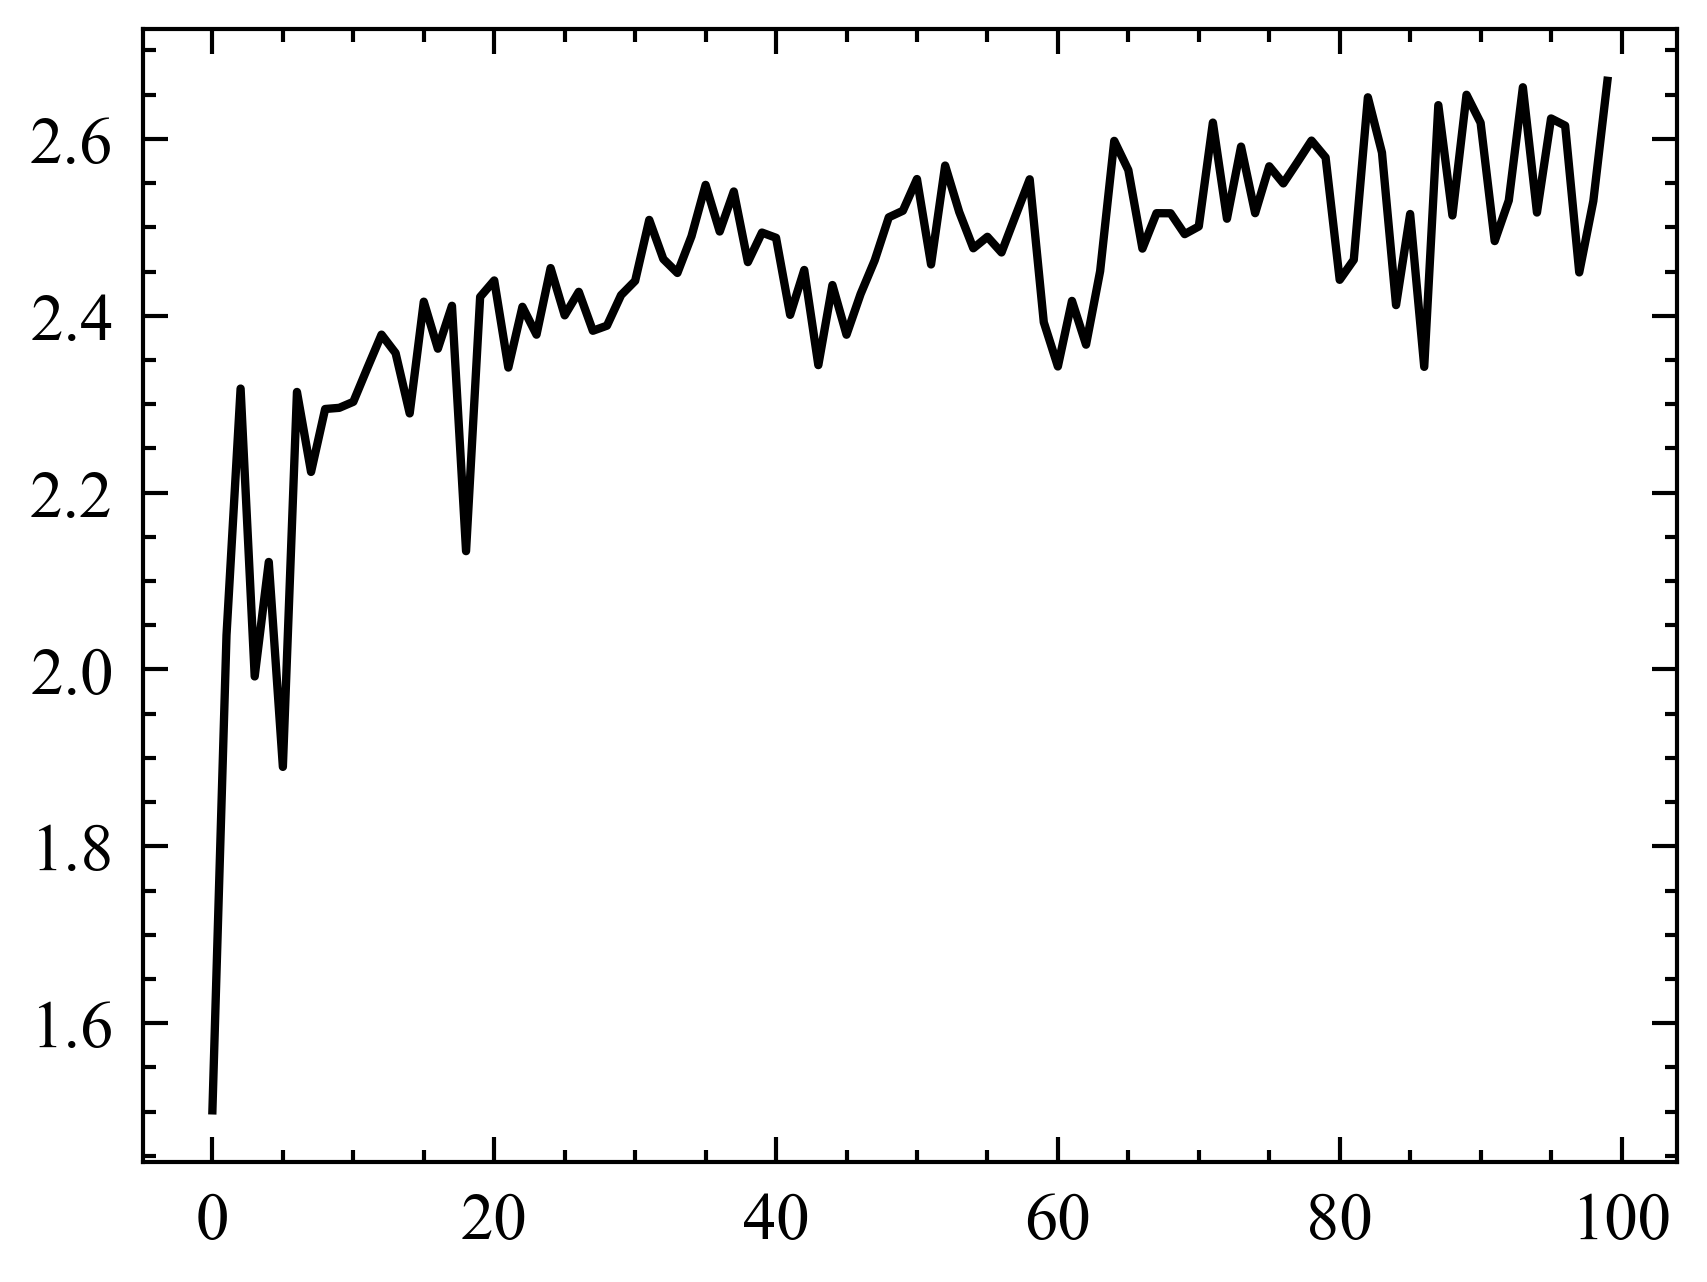

In [152]:
plt.plot(np.arange(epo),acc_012, label='Test label=0,1,2 accuracy')

In [161]:
(traindata-np.mean(traindata,0))/np.std(traindata,0)

array([[-0.19963663, -0.20136155, -0.19875438, ..., -0.24702566,
        -0.24810528, -0.24682546],
       [-0.20352582, -0.19315009, -0.19980054, ..., -0.22076152,
        -0.2190737 , -0.21665331],
       [-0.14711496, -0.14990541, -0.15362046, ..., -0.18079979,
        -0.17618395, -0.16071745],
       ...,
       [-0.21222624, -0.2103401 , -0.20690737, ..., -0.25322656,
        -0.25308503, -0.25320876],
       [-0.21225374, -0.20973302, -0.20615388, ..., -0.25230832,
        -0.25178537, -0.25213684],
       [-0.2115584 , -0.21016239, -0.20594242, ..., -0.25195697,
        -0.25210153, -0.25224008]])

In [158]:
data_scaled

array([[-0.19963663, -0.20136155, -0.19875438, ..., -0.24702566,
        -0.24810528, -0.24682546],
       [-0.20352582, -0.19315009, -0.19980054, ..., -0.22076152,
        -0.2190737 , -0.21665331],
       [-0.14711496, -0.14990541, -0.15362046, ..., -0.18079979,
        -0.17618395, -0.16071745],
       ...,
       [-0.21222624, -0.2103401 , -0.20690737, ..., -0.25322656,
        -0.25308503, -0.25320876],
       [-0.21225374, -0.20973302, -0.20615388, ..., -0.25230832,
        -0.25178537, -0.25213684],
       [-0.2115584 , -0.21016239, -0.20594242, ..., -0.25195697,
        -0.25210153, -0.25224008]])

In [162]:

    
#输出结果
def predict(testdata, model):
    
    predictions = model.predict(testdata)
    predicted_label=np.zeros(predictions.shape[0])
    for i in range(predictions.shape[0]):
        predicted_label[i] = np.argmax(predictions[i])
    return predicted_label


loaded_model = tf.keras.models.load_model('/data/dell5/userdir/chenhx/galaxy10/sepctra_ann_models_resample/epoch_99.h5')

pre_labels=predict((testdata-np.mean(traindata,0))/np.std(traindata,0), loaded_model)


32/32 [==============================] - 0s 2ms/step


In [163]:

print(np.sum(pre_labels==0),np.sum(pre_labels==1))

181 164


In [164]:
import csv

csv_reader=csv.reader(open("test_csv.csv"))
for row in csv_reader:
    print(row)


with open("test_csv.csv","w",encoding="utf-8",newline="") as f:
    csv_writer=csv.writer(f)
    name=['obj_id','predicted_label']
    
    csv_writer.writerow(name)
    
    z=[list(testid),list(pre_labels)]
    z=np.array(z).reshape(2,1000).T
    for i in range(1000):
        csv_writer.writerow(z[i])
    
    f.close()

    

['obj_id', 'predicted_label']
['20001.0', '2.0']
['20002.0', '2.0']
['20003.0', '2.0']
['20004.0', '2.0']
['20005.0', '2.0']
['20006.0', '2.0']
['20007.0', '2.0']
['20008.0', '2.0']
['20009.0', '2.0']
['20010.0', '2.0']
['20011.0', '2.0']
['20012.0', '2.0']
['20013.0', '2.0']
['20014.0', '2.0']
['20015.0', '2.0']
['20016.0', '2.0']
['20017.0', '2.0']
['20018.0', '2.0']
['20019.0', '2.0']
['20020.0', '2.0']
['20021.0', '2.0']
['20022.0', '2.0']
['20023.0', '2.0']
['20024.0', '2.0']
['20025.0', '2.0']
['20026.0', '2.0']
['20027.0', '2.0']
['20028.0', '2.0']
['20029.0', '2.0']
['20030.0', '2.0']
['20031.0', '2.0']
['20032.0', '2.0']
['20033.0', '2.0']
['20034.0', '2.0']
['20035.0', '2.0']
['20036.0', '2.0']
['20037.0', '2.0']
['20038.0', '2.0']
['20039.0', '2.0']
['20040.0', '2.0']
['20041.0', '2.0']
['20042.0', '2.0']
['20043.0', '2.0']
['20044.0', '2.0']
['20045.0', '2.0']
['20046.0', '2.0']
['20047.0', '2.0']
['20048.0', '2.0']
['20049.0', '2.0']
['20050.0', '2.0']
['20051.0', '2.0']
[

In [110]:
z=np.zeros([1000,2])
z[:,0]=testid.copy()
z[:,1]=pre_labels.copy()

In [118]:
z=np.array(z).reshape(1000,2)

In [130]:
list(z[0])

[20001.0, 2.0]

In [ ]:
#残差神经网络模型

In [85]:
# learning=1e-6
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
import os

# 数据预处理
scaler = StandardScaler()
data_scaled = scaler.fit_transform(traindata)

# 数据洗牌
data_shuffled, labels_shuffled = shuffle(data_scaled, trainlabel, random_state=42)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(data_shuffled, labels_shuffled, test_size=0.1, random_state=42)


#分离label0 和label1
X_test0=X_test[y_test==0]
y_test0=y_test[y_test==0]
X_test1=X_test[y_test==1]
y_test1=y_test[y_test==1]

# 构建神经网络模型
# 定义残差块
def residual_block(x, units):
    y = tf.keras.layers.Dense(units, activation='relu')(x)
    #y = tf.keras.layers.Dense(units, activation=None)(y)
    shortcut = tf.keras.layers.Dense(units, activation=None)(x)  # 添加一个全连接层，以匹配形状
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Add()([shortcut, y])  # 将输入和残差连接起来
    y = tf.keras.layers.Activation('relu')(y)
    return y

# 构建残差神经网络模型
input_layer = tf.keras.layers.Input(shape=(3000,))
x = input_layer


#for _ in range(3):  # 在这里重复添加残差块的层数
x = residual_block(x, 1024)
x = residual_block(x, 256)
x = residual_block(x, 64)

#x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
output_layer = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)




model.summary()


# 计算类别权重
class_weights = {
    0: len(trainlabel) / (3 * 3427)*2,  # 类别0的权重
    1: len(trainlabel) / (3 * 1011)*6,  # 类别1的权重
    2: len(trainlabel) / (3 * 95562)  # 类别2的权重
}




# 编译模型时设置类别权重
optimizer = Adam(learning_rate=0.000001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])#,  class_weight=class_weights)



epo=40
trainL=np.zeros(epo)
testL=np.zeros(epo)
trainacc=np.zeros(epo)
testacc=np.zeros(epo)
testL0=np.zeros(epo)
testacc0=np.zeros(epo)
testL1=np.zeros(epo)
testacc1=np.zeros(epo)

if not os.path.exists('/data/dell5/userdir/chenhx/galaxy10/sepctra_res_models'):
    os.makedirs('/data/dell5/userdir/chenhx/galaxy10/sepctra_res_models')


    
for epoch in range(epo):  
        history=model.fit(X_train, y_train, batch_size=64, epochs=1, validation_split=0.1,class_weight=class_weights)
        model.save(f'/data/dell5/userdir/chenhx/galaxy10/sepctra_res_models/epoch_{epoch+1}.h5')
        test_loss, test_acc = model.evaluate(X_test, y_test)
        print('Test all accuracy:', test_acc)
        
        test_loss0, test_acc0 = model.evaluate(X_test0, y_test0)
        print('Test label=0 accuracy:', test_acc0)
        test_loss1, test_acc1 = model.evaluate(X_test1, y_test1)
        print('Test label=1 accuracy:', test_acc1)
        
        trainL[epoch]=history.history['loss'][0]
        testL[epoch]=test_loss
        trainacc[epoch]=history.history['accuracy'][0]
        testacc[epoch]=test_acc
        #分离label=0,1
        testL0[epoch]=test_loss0
        testacc0[epoch]=test_acc0
        
        testL1[epoch]=test_loss1
        testacc1[epoch]=test_acc1
        
        


# 评估模型
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)



Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 3000)]               0         []                            
                                                                                                  
 dense_170 (Dense)           (None, 1024)                 3073024   ['input_14[0][0]']            
                                                                                                  
 dense_171 (Dense)           (None, 1024)                 3073024   ['input_14[0][0]']            
                                                                                                  
 batch_normalization_31 (Ba  (None, 1024)                 4096      ['dense_170[0][0]']           
 tchNormalization)                                                                         

/home/chenghx/anaconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 1s 2ms/step - loss: 1.4565 - accuracy: 0.1790
Test all accuracy: 0.17900000512599945
11/11 [==============================] - 0s 3ms/step - loss: 0.6006 - accuracy: 1.0000
Test label=0 accuracy: 1.0
4/4 [==============================] - 0s 3ms/step - loss: 1.0254 - accuracy: 0.0000e+00
Test label=1 accuracy: 0.0
313/313 [==============================] - 1s 2ms/step - loss: 1.4031 - accuracy: 0.2393
Test all accuracy: 0.23929999768733978
11/11 [==============================] - 0s 3ms/step - loss: 1.5606 - accuracy: 0.0152
Test label=0 accuracy: 0.015197568573057652
4/4 [==============================] - 0s 3ms/step - loss: 0.3097 - accuracy: 0.9899
Test label=1 accuracy: 0.9898989796638489
313/313 [==============================] - 1s 3ms/step - loss: 1.4956 - accuracy: 0.2466
Test all accuracy: 0.24660000205039978
11/11 [==============================] - 0s 3ms/step - loss: 0.2290 - accuracy: 1.0000
Test label=0 accuracy: 1.0
4/4 [=========

313/313 [==============================] - 1s 2ms/step - loss: 1.4606 - accuracy: 0.5903
Test all accuracy: 0.5903000235557556
11/11 [==============================] - 0s 3ms/step - loss: 2.6206 - accuracy: 0.0304
Test label=0 accuracy: 0.030395137146115303
4/4 [==============================] - 0s 4ms/step - loss: 0.0464 - accuracy: 1.0000
Test label=1 accuracy: 1.0
313/313 [==============================] - 1s 2ms/step - loss: 1.6445 - accuracy: 0.5435
Test all accuracy: 0.5435000061988831
11/11 [==============================] - 0s 3ms/step - loss: 4.4871 - accuracy: 0.0000e+00
Test label=0 accuracy: 0.0
4/4 [==============================] - 0s 3ms/step - loss: 0.0297 - accuracy: 1.0000
Test label=1 accuracy: 1.0
313/313 [==============================] - 1s 3ms/step - loss: 1.8493 - accuracy: 0.4485
Test all accuracy: 0.44850000739097595
11/11 [==============================] - 0s 3ms/step - loss: 2.9945 - accuracy: 0.0547
Test label=0 accuracy: 0.054711245000362396
4/4 [=========

313/313 [==============================] - 1s 4ms/step - loss: 1.2503 - accuracy: 0.6062
Test all accuracy: 0.6061999797821045
11/11 [==============================] - 0s 4ms/step - loss: 2.2182 - accuracy: 0.0304
Test label=0 accuracy: 0.030395137146115303
4/4 [==============================] - 0s 4ms/step - loss: 0.0851 - accuracy: 0.9899
Test label=1 accuracy: 0.9898989796638489
313/313 [==============================] - 1s 4ms/step - loss: 1.3187 - accuracy: 0.5959
Test all accuracy: 0.5958999991416931
11/11 [==============================] - 0s 4ms/step - loss: 2.7732 - accuracy: 0.0030
Test label=0 accuracy: 0.0030395137146115303
4/4 [==============================] - 0s 5ms/step - loss: 0.0391 - accuracy: 1.0000
Test label=1 accuracy: 1.0
313/313 [==============================] - 1s 4ms/step - loss: 0.9121 - accuracy: 0.6114
Test all accuracy: 0.6114000082015991
11/11 [==============================] - 0s 4ms/step - loss: 2.4678 - accuracy: 0.0122
Test label=0 accuracy: 0.01215

In [ ]:
plt.figure(figsize=(7,3))
plt.subplot(1, 2, 1)
plt.plot(np.arange(epo),trainL, label='Training Loss')
plt.plot(np.arange(epo),testL, label='Test all Loss')
plt.plot(np.arange(epo),testL0, label='Test label=0 Loss')
plt.plot(np.arange(epo),testL1, label='Test label=1 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(epo),trainacc, label='Training accuracy')
plt.plot(np.arange(epo),testacc, label='Test all accuracy')
plt.plot(np.arange(epo),testacc0, label='Test label=0 accuracy')
plt.plot(np.arange(epo),testacc1, label='Test label=1 accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test accuracy')
plt.legend()

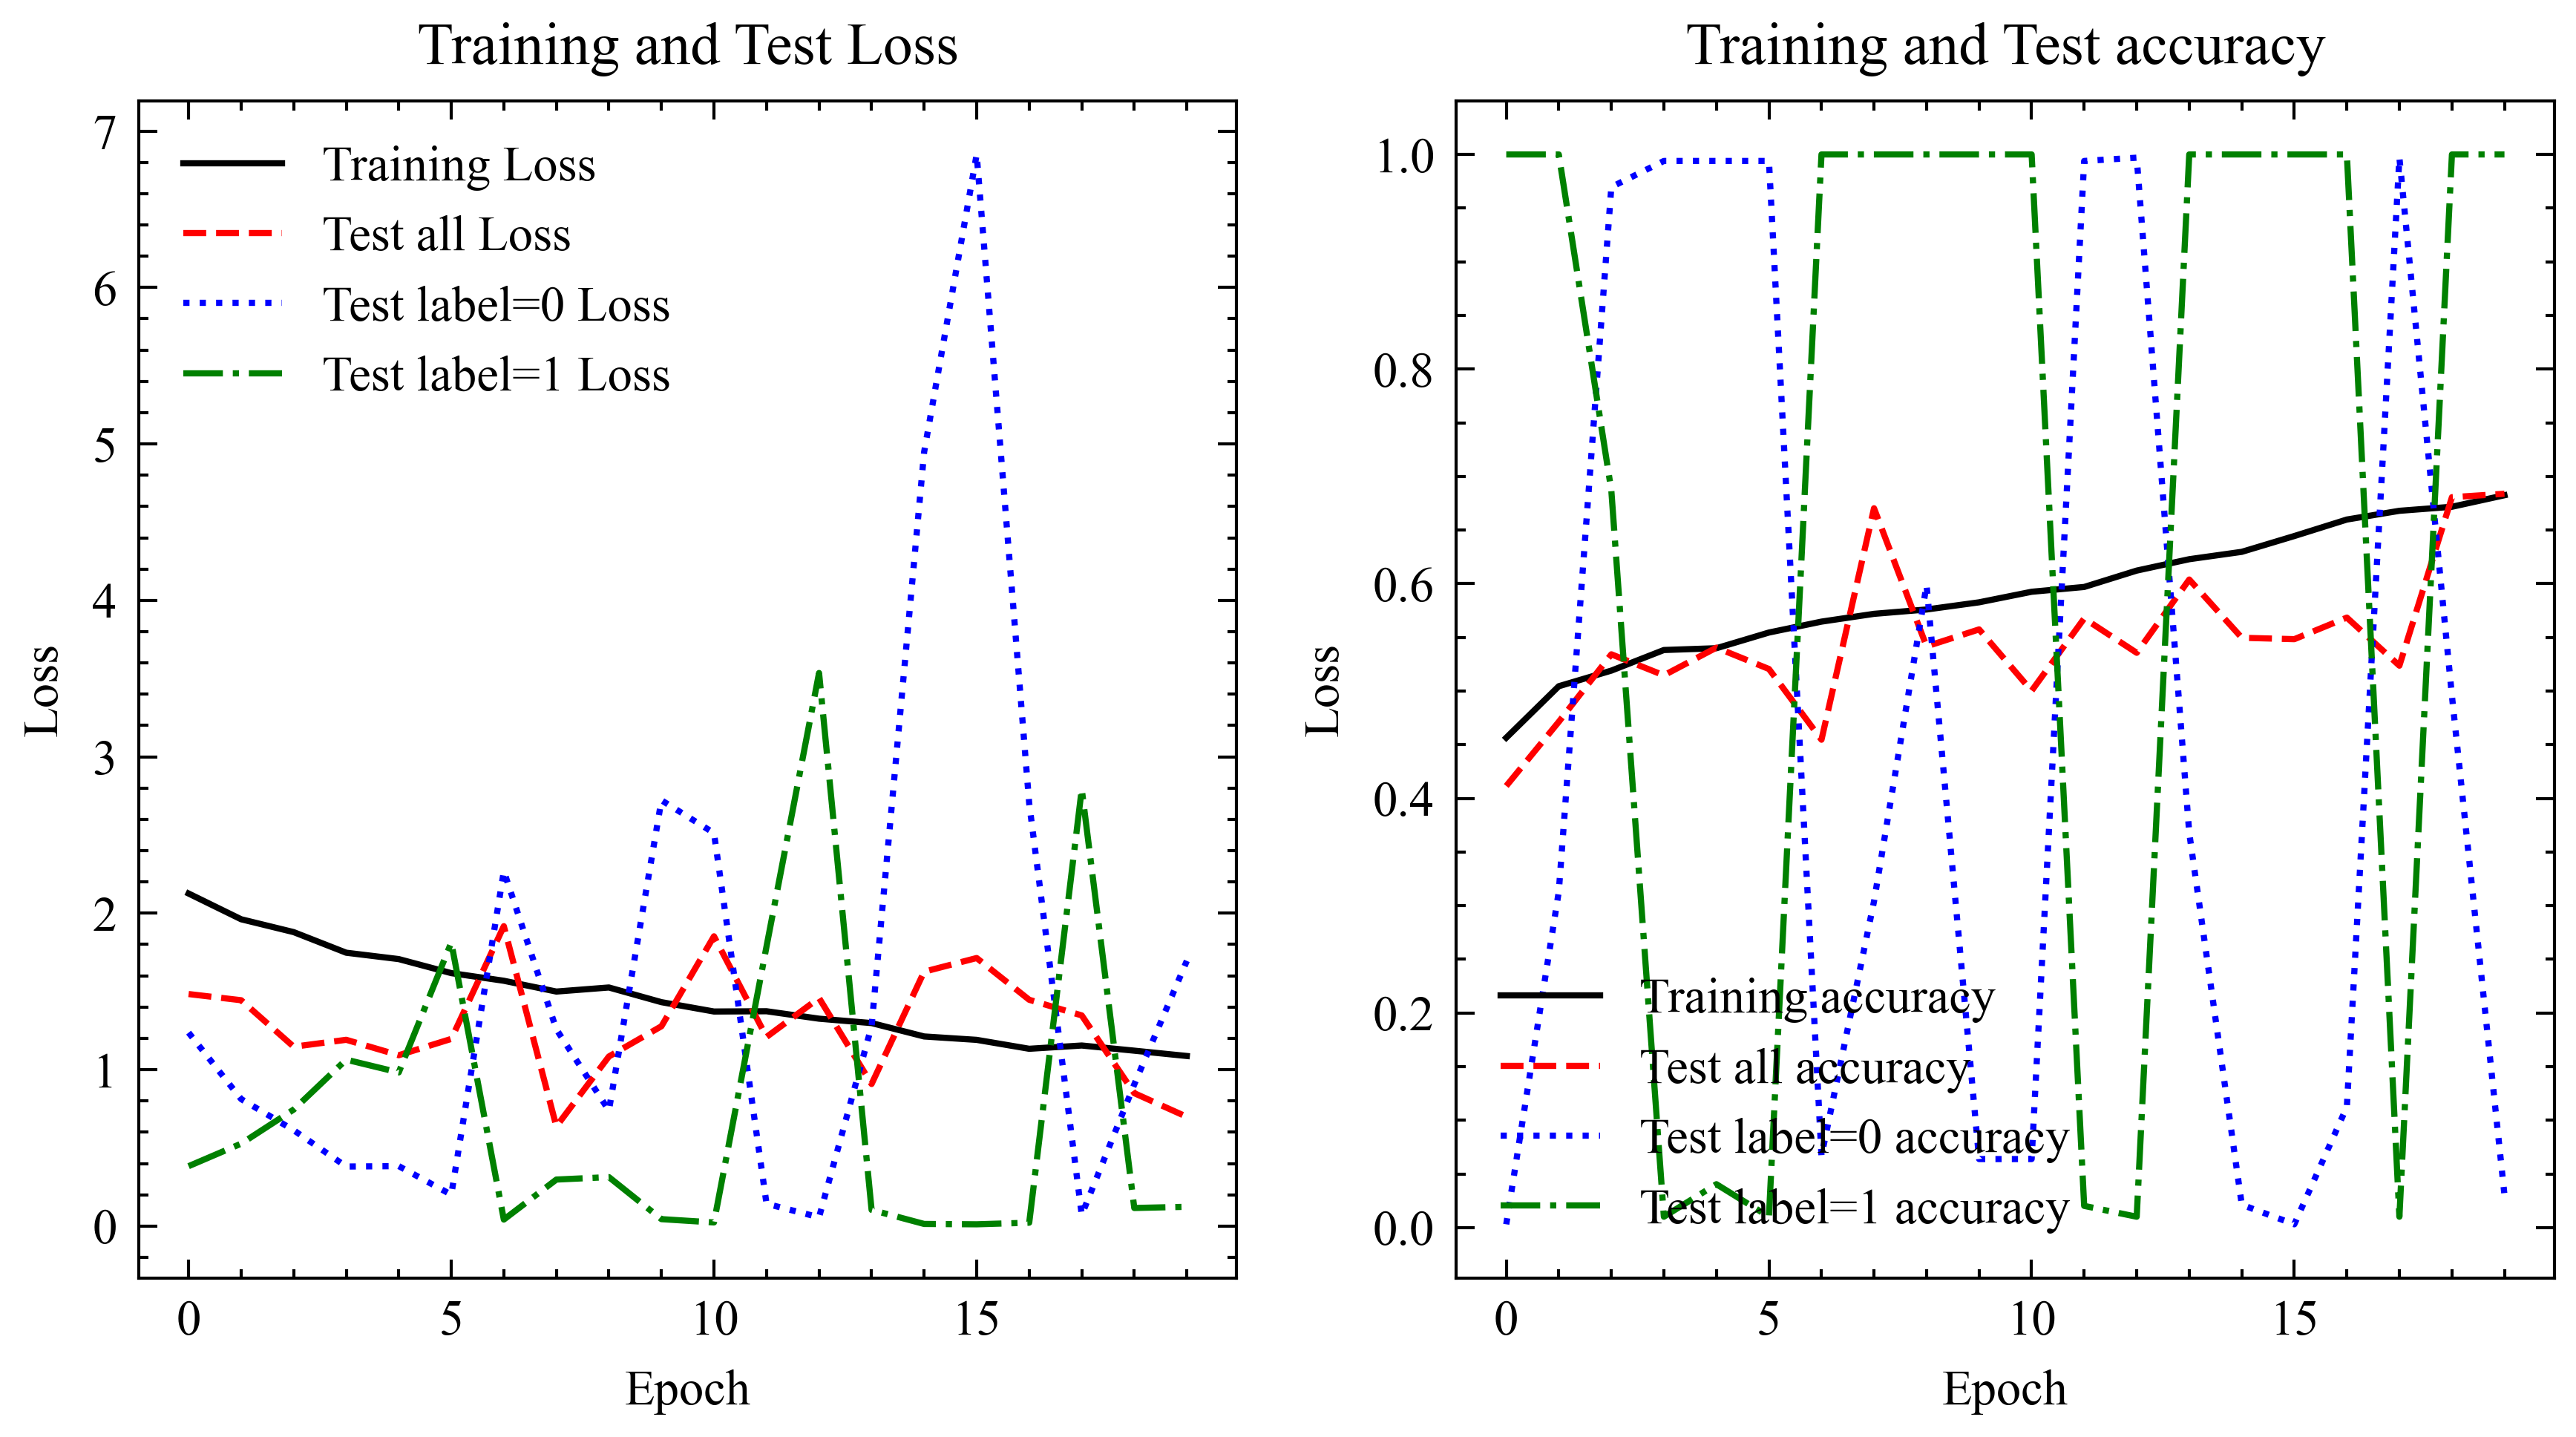

In [70]:
plt.figure(figsize=(7,3.5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(epo)[:20],trainL[:20], label='Training Loss')
plt.plot(np.arange(epo)[:20],testL[:20], label='Test all Loss')
plt.plot(np.arange(epo)[:20],testL0[:20], label='Test label=0 Loss')
plt.plot(np.arange(epo)[:20],testL1[:20], label='Test label=1 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(epo)[:20],trainacc[:20], label='Training accuracy')
plt.plot(np.arange(epo)[:20],testacc[:20], label='Test all accuracy')
plt.plot(np.arange(epo)[:20],testacc0[:20], label='Test label=0 accuracy')
plt.plot(np.arange(epo)[:20],testacc1[:20], label='Test label=1 accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test accuracy')
plt.legend()